In [2]:
import time, statistics as stats
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

def timeit_ms(fn, *args, repeat=50, warmup=10, **kwargs):
    for _ in range(warmup):
        fn(*args, **kwargs)
    t = []
    for _ in range(repeat):
        t0 = time.perf_counter()
        fn(*args, **kwargs)
        t.append((time.perf_counter() - t0) * 1000.0)
    return {"mean_ms": round(stats.mean(t), 3),
            "std_ms": round(stats.pstdev(t), 3),
            "repeat": repeat}

In [5]:
from torch.utils.cpp_extension import load_inline
import torch 
source = """ 
#include <torch/extension.h>

at::Tensor gemm(const at::Tensor& A, const at::Tensor& B)
{
    TORCH_CHECK(A.dtype() == torch::kInt32, "A must be int32");
    TORCH_CHECK(B.dtype() == torch::kInt32, "B must be int32");
    TORCH_CHECK(A.dim() == 2, "A must be 2D");
    TORCH_CHECK(B.dim() == 2, "B must be 2D");
    TORCH_CHECK(A.device().is_cpu(), "A must be on CPU");
    TORCH_CHECK(B.device().is_cpu(), "B must be on CPU");

    auto A_contig = A.contiguous();
    auto B_contig = B.contiguous();

    const int64_t M = A_contig.size(0);
    const int64_t K1 = A_contig.size(1);
    const int64_t K2 = B_contig.size(0);
    const int64_t N = B_contig.size(1);

    TORCH_CHECK(K1 == K2, "Inner dims must match: A[M,K], B[K,N]");
    const int64_t K  = K1;

    const int32_t* A_ptr = A_contig.data_ptr<int32_t>();
    const int32_t* B_ptr = B_contig.data_ptr<int32_t>();

    auto C = torch::zeros({M, N}, A_contig.options());
    int32_t* C_ptr = C.data_ptr<int32_t>();

    for (int64_t i = 0; i < M; ++i)
    {
        const int32_t* rowA_ptr = A_ptr + i * K;
        int32_t* rowC_ptr = C_ptr + i * N;

        for (int64_t k = 0; k < K; ++k)
        {
            const int32_t a_ik = rowA_ptr[k];
            const int32_t* rowB_ptr = B_ptr + k * N;

            for (int64_t j = 0; j < N; ++j)
            {
                rowC_ptr[j] += a_ik * rowB_ptr[j];
            }
        }
    }

    return C;
}

TORCH_LIBRARY(my_op, m)
{
    m.def("gemm", &gemm);
}
"""

module = load_inline(name="my_op",
                    cpp_sources=[source],
                    is_python_module=False,
                    verbose=True,
                    extra_cflags=["-O3", "-std=c++20", "-march=native"],
                    with_cuda=False)
gemm = torch.ops.my_op.gemm

Using C:\Users\user\AppData\Local\torch_extensions\torch_extensions\Cache\py313_cu126 as PyTorch extensions root...
Emitting ninja build file C:\Users\user\AppData\Local\torch_extensions\torch_extensions\Cache\py313_cu126\my_op\build.ninja...
Building extension module my_op...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module my_op...


In [3]:
from torch.utils.cpp_extension import load_inline
import torch 
source = """ 
#include <torch/extension.h>
#include <bit>

torch::Tensor pack_row(const torch::Tensor& A) {
    TORCH_CHECK(A.device().is_cpu(), "CPU only");
    TORCH_CHECK(A.dim() == 2, "expected 2D tensor");
    TORCH_CHECK(A.scalar_type() == torch::kFloat);

    auto A_contig = A.contiguous();

    const int64_t M = A_contig.size(0);
    const int64_t K = A_contig.size(1);
    const int64_t nblocks = (K + 63) / 64;

    auto opts = torch::TensorOptions()
                    .dtype(torch::kLong)
                    .device(torch::kCPU);

    auto packed = torch::zeros({M, nblocks}, opts);

    const float* A_ptr = A_contig.data_ptr<float>();
    int64_t* P_ptr = packed.data_ptr<int64_t>();

    for (int64_t i = 0; i < M; ++i) {
        const float* rowA = A_ptr + i * K;
        int64_t* rowP = P_ptr + i * nblocks;

        for (int64_t k = 0; k < K; ++k) {
            const int64_t blk = k >> 6; //< k / 64
            const int64_t off = k & 63; //< k % 64

            bool bit = (rowA[k] > 0);
            rowP[blk] |= (static_cast<int64_t>(bit) << off);
        }
    }

    return packed;
}

torch::Tensor pack_col(const torch::Tensor& B) {
    TORCH_CHECK(B.device().is_cpu(), "CPU only");
    TORCH_CHECK(B.dim() == 2, "expected 2D tensor");
    TORCH_CHECK(B.scalar_type() == torch::kFloat);

    auto B_contig = B.contiguous();

    const int64_t K = B_contig.size(0);
    const int64_t N = B_contig.size(1);
    const int64_t nblocks = (K + 63) / 64;

    auto opts = torch::TensorOptions()
                    .dtype(torch::kLong)
                    .device(torch::kCPU);

    auto packed = torch::zeros({N, nblocks}, opts);

    const float*  B_ptr = B_contig.data_ptr<float>();
    int64_t* P_ptr = packed.data_ptr<int64_t>();

    for (int64_t j = 0; j < N; ++j) {
        int64_t* rowP = P_ptr + j * nblocks;

        for (int64_t k = 0; k < K; ++k) {
            const int64_t blk = k >> 6; //< k / 64
            const int64_t off = k & 63; //< k % 64

            bool bit = (B_ptr[k * N + j] > 0);
            rowP[blk] |= (static_cast<int64_t>(bit) << off);
        }
    }

    return packed;
}

TORCH_LIBRARY(my_op_pack, m)
{
    m.def("pack_row", &pack_row);
    m.def("pack_col", &pack_col);
}
"""

module = load_inline(name="my_op_pack",
                    cpp_sources=[source],
                    is_python_module=False,
                    verbose=True,
                    extra_cflags=["-O3", "-std=c++20", "-march=native"],
                    with_cuda=False)
pack_row = torch.ops.my_op_pack.pack_row
pack_col = torch.ops.my_op_pack.pack_col

Using C:\Users\user\AppData\Local\torch_extensions\torch_extensions\Cache\py313_cu126 as PyTorch extensions root...
The input conditions for extension module my_op_pack have changed. Bumping to version 1 and re-building as my_op_pack_v1...
Emitting ninja build file C:\Users\user\AppData\Local\torch_extensions\torch_extensions\Cache\py313_cu126\my_op_pack\build.ninja...
Building extension module my_op_pack_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module my_op_pack_v1...


In [ ]:
def to_binary64(x):
    return format(x & ((1 << 64) - 1), "064b")

In [34]:
A = torch.rand((64, 64), dtype=torch.float32)
A = (A-A.mean()).sign()

packed = pack_row(A)
assert(packed.shape == (64, 1))
assert(packed.dtype == torch.int64)

print(A[0])
print(packed[0][0])
print(to_binary64(packed[0][0].item()))
for target, block in zip(A, packed):
    val = to_binary64(block[0].item())
    for i in range(64):
        ti = str((target[i]>0).to(dtype=torch.int8).item())
        assert(ti ==val[63-i])

tensor([ 1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1., -1., -1., -1.,  1.,
        -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1., -1., -1., -1., -1.,
        -1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,
        -1., -1.,  1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1.,
         1., -1., -1.,  1., -1., -1., -1.,  1.])
tensor(-8571384234711997843)
1000100100001100010100110111001110100000100110111010001001101101


In [36]:
packed = pack_col(A)
assert(packed.shape == (64, 1))
assert(packed.dtype == torch.int64)

print(A[:, 0])
print(packed[0, 0])
print(to_binary64(packed[0, 0].item()))
for j in range(64):
    val = to_binary64(packed[j, 0].item())
    for i in range(64):
        ti = str((A[i, j]>0).to(dtype=torch.int8).item())
        assert(ti ==val[63-i])

tensor([ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1., -1.,  1., -1.,  1.,
        -1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,
        -1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,
         1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,
        -1., -1., -1., -1., -1.,  1.,  1.,  1.])
tensor(-2281383989182944705)
1110000001010110111001010101100101100000011111001010101000111111


In [40]:
res = {
    "n": [],
    "pack_row mean_ms": [],
    "pack_row std_ms": [],
    "pack_col mean_ms": [],
    "pack_col std_ms": [],
}

for i in tqdm(range(1, 9)):
    n = int(torch.e ** i)
    res["n"].append(n)

    A = torch.randint(0, 2, (n, n), dtype=torch.float32)

    r_pack_row = timeit_ms(pack_row, A, repeat=3, warmup=1)
    res["pack_row mean_ms"].append(r_pack_row["mean_ms"])
    res["pack_row std_ms"].append(r_pack_row["std_ms"])

    r_pack_col = timeit_ms(pack_col, A, repeat=3, warmup=1)
    res["pack_col mean_ms"].append(r_pack_col["mean_ms"])
    res["pack_col std_ms"].append(r_pack_col["std_ms"])

100%|██████████| 8/8 [00:00<00:00,  8.92it/s]


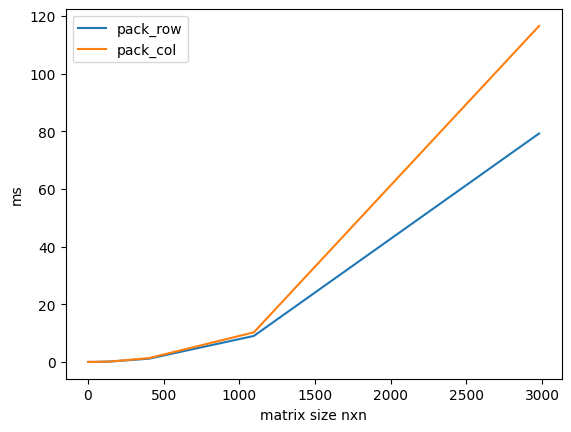

In [41]:
plt.plot(res["n"], res["pack_row mean_ms"], label="pack_row")
plt.plot(res["n"], res["pack_col mean_ms"], label="pack_col")
plt.ylabel("ms")
plt.xlabel("matrix size nxn")
plt.legend()

In [3]:
from torch.utils.cpp_extension import load_inline
import torch 
source = """ 
#include <torch/extension.h>
#include <cstdint>

static inline std::uint32_t popcnt_u64(std::uint64_t v) {
#ifdef _MSC_VER
    return static_cast<std::uint32_t>(__popcnt64(v));
#else
    return static_cast<std::uint32_t>(__builtin_popcountll(static_cast<unsigned long long>(v)));
#endif
}

torch::Tensor pack_row(const torch::Tensor& A)
{
    TORCH_CHECK(A.dim() == 2, "expected 2D tensor");
    TORCH_CHECK(A.scalar_type() == torch::kFloat);

    auto A_contig = A.contiguous();

    const int64_t M = A_contig.size(0);
    const int64_t K = A_contig.size(1);
    const int64_t nblocks = (K + 63) / 64;

    auto opts = torch::TensorOptions()
                    .dtype(torch::kLong)
                    .device(torch::kCPU);

    auto packed = torch::zeros({M, nblocks}, opts);

    const float* A_ptr = A_contig.data_ptr<float>();
    int64_t* P_ptr = packed.data_ptr<int64_t>();

    for (int64_t i = 0; i < M; ++i) {
        const float* rowA = A_ptr + i * K;
        int64_t* rowP = P_ptr + i * nblocks;

        for (int64_t k = 0; k < K; ++k) {
            const int64_t blk = k >> 6; //< k / 64
            const int64_t off = k & 63; //< k % 64

            bool bit = (rowA[k] > 0);
            rowP[blk] |= (static_cast<int64_t>(bit) << off);
        }
    }

    return packed;
}

torch::Tensor pack_col(const torch::Tensor& B) {
    TORCH_CHECK(B.dim() == 2, "expected 2D tensor");
    TORCH_CHECK(B.scalar_type() == torch::kFloat);

    auto B_contig = B.contiguous();

    const int64_t K = B_contig.size(0);
    const int64_t N = B_contig.size(1);
    const int64_t nblocks = (K + 63) / 64;

    auto opts = torch::TensorOptions()
                    .dtype(torch::kLong)
                    .device(torch::kCPU);

    auto packed = torch::zeros({N, nblocks}, opts);

    const float*  B_ptr = B_contig.data_ptr<float>();
    int64_t* P_ptr = packed.data_ptr<int64_t>();

    for (int64_t j = 0; j < N; ++j) {
        int64_t* rowP = P_ptr + j * nblocks;

        for (int64_t k = 0; k < K; ++k) {
            const int64_t blk = k >> 6; //< k / 64
            const int64_t off = k & 63; //< k % 64

            bool bit = (B_ptr[k * N + j] > 0);
            rowP[blk] |= (static_cast<int64_t>(bit) << off);
        }
    }

    return packed;
}

torch::Tensor bin_matmul_xnor_popcnt_tensor(const torch::Tensor& A, const torch::Tensor& B)
{
    TORCH_CHECK(A.device().is_cpu() && B.device().is_cpu(), "CPU only");
    TORCH_CHECK(A.dim() == 2 && B.dim() == 2, "expected 2D tensors");
    TORCH_CHECK(
        (A.scalar_type() == torch::kFloat) &&
        (B.scalar_type() == torch::kFloat)
    );

    const int64_t M  = A.size(0);
    const int64_t K  = A.size(1);
    const int64_t K2 = B.size(0);
    const int64_t N  = B.size(1);

    TORCH_CHECK(K == K2, "inner dimensions must match");

    auto A_packed = pack_row(A);   // int64, [M, nblocks]
    auto B_packed = pack_col(B);   // int64, [N, nblocks]

    A_packed = A_packed.contiguous();
    B_packed = B_packed.contiguous();

    const int64_t nb  = A_packed.size(1);
    TORCH_CHECK(A_packed.size(0) == M);
    TORCH_CHECK(B_packed.size(0) == N);
    TORCH_CHECK(B_packed.size(1) == nb, "inconsistent nblocks between A and B");

    auto out_opts = torch::TensorOptions()
                        .dtype(torch::kInt32)
                        .device(torch::kCPU);

    auto C = torch::empty({M, N}, out_opts);

    // маска для последнего блока
    const int64_t valid_tail = (K & 63);
    const std::uint64_t tail_mask =
        (valid_tail == 0)
        ? ~std::uint64_t{0}                        //< все биты валидны
        : ((std::uint64_t{1} << valid_tail) - 1u); //< только K%64 младших битов

    const int64_t* A_ptr = A_packed.data_ptr<int64_t>();
    const int64_t* B_ptr = B_packed.data_ptr<int64_t>();
    int32_t* C_ptr = C.data_ptr<int32_t>();

    for (int64_t i = 0; i < M; ++i) {
        const int64_t* rowA = A_ptr + i * nb;
        int32_t* rowC = C_ptr + i * N;

        for (int64_t j = 0; j < N; ++j) {
            const int64_t* rowB = B_ptr + j * nb;

            std::uint32_t equal_bits = 0;

            for (int64_t blk = 0; blk < nb; ++blk) {
                std::uint64_t a = static_cast<std::uint64_t>(rowA[blk]);
                std::uint64_t b = static_cast<std::uint64_t>(rowB[blk]);

                std::uint64_t x = ~(a ^ b); //< XNOR

                if (blk == nb - 1) {
                    x &= tail_mask;
                }

                equal_bits += popcnt_u64(x);
            }

            // Т.к. входы {+1,-1}, то dot = 2 * (equal_bits) - K
            const int32_t dot = 2 * static_cast<int32_t>(equal_bits)
                                     - static_cast<int32_t>(K);

            rowC[j] = dot;
        }
    }
    return C;
}


TORCH_LIBRARY(my_op_2, m)
{
    m.def("bin_matmul_xnor_popcnt_tensor", &bin_matmul_xnor_popcnt_tensor);
}
"""

module = load_inline(name="my_op_2",
                    cpp_sources=[source],
                    is_python_module=False,
                    verbose=True,
                    extra_cflags=["-O3", "-std=c++20", "-march=native"],
                    with_cuda=False)
bin_matmul_xnor_popcnt_tensor = torch.ops.my_op_2.bin_matmul_xnor_popcnt_tensor

Using C:\Users\user\AppData\Local\torch_extensions\torch_extensions\Cache\py313_cu126 as PyTorch extensions root...
The input conditions for extension module my_op_2 have changed. Bumping to version 1 and re-building as my_op_2_v1...
Emitting ninja build file C:\Users\user\AppData\Local\torch_extensions\torch_extensions\Cache\py313_cu126\my_op_2\build.ninja...
Building extension module my_op_2_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module my_op_2_v1...


In [4]:
A = torch.randint(0, 2, (64, 128), dtype=torch.float32)
A = (A-A.mean()).sign()
B = torch.randint(0, 2, (128, 256), dtype=torch.float32)
B = (B-B.mean()).sign()
print((torch.matmul(A, B) != bin_matmul_xnor_popcnt_tensor(A, B)).sum())

A = torch.randint(0, 2, (64, 64), dtype=torch.float32)
A = (A-A.mean()).sign()
B = torch.randint(0, 2, (64, 64), dtype=torch.float32)
B = (B-B.mean()).sign()
print((torch.matmul(A, B) != bin_matmul_xnor_popcnt_tensor(A, B)).sum())

A = torch.randint(0, 2, (10, 20), dtype=torch.float32)
A = (A-A.mean()).sign()
B = torch.randint(0, 2, (20, 30), dtype=torch.float32)
B = (B-B.mean()).sign()
print((torch.matmul(A, B) != bin_matmul_xnor_popcnt_tensor(A, B)).sum())

A = torch.randint(0, 2, (1000, 4000), dtype=torch.float32)
A = (A-A.mean()).sign()
B = torch.randint(0, 2, (4000, 5000), dtype=torch.float32)
B = (B-B.mean()).sign()
print((torch.matmul(A, B) != bin_matmul_xnor_popcnt_tensor(A, B)).sum())

tensor(0)
tensor(0)
tensor(0)
tensor(0)


In [6]:
res = {
    "n": [],
    "torch mean_ms": [],
    "torch std_ms": [],
    "gemm mean_ms": [],
    "gemm std_ms": [],
    "bin_matmul_xnor_popcnt_tensor mean_ms": [],
    "bin_matmul_xnor_popcnt_tensor std_ms": [],
}

for i in tqdm(range(1, 9)):
    n = int(torch.e ** i)
    res["n"].append(n)

    A = torch.randint(0, 2, (n, n), dtype=torch.float32)
    A = (A-A.mean()).sign()
    B = torch.randint(0, 2, (n, n), dtype=torch.float32)
    B = (B-B.mean()).sign()

    Ai = A.to(torch.int32)
    Bi = B.to(torch.int32)

    r_torch = timeit_ms(torch.matmul, Ai, Bi, repeat=3, warmup=1)
    res["torch mean_ms"].append(r_torch["mean_ms"])
    res["torch std_ms"].append(r_torch["std_ms"])

    r_gemm = timeit_ms(gemm, Ai, Bi, repeat=3, warmup=1)
    res["gemm mean_ms"].append(r_gemm["mean_ms"])
    res["gemm std_ms"].append(r_gemm["std_ms"])

    r_bin_matmul_xnor_popcnt_tensor = timeit_ms(bin_matmul_xnor_popcnt_tensor, A, B, repeat=3, warmup=1)
    res["bin_matmul_xnor_popcnt_tensor mean_ms"].append(r_bin_matmul_xnor_popcnt_tensor["mean_ms"])
    res["bin_matmul_xnor_popcnt_tensor std_ms"].append(r_bin_matmul_xnor_popcnt_tensor["std_ms"])

100%|██████████| 8/8 [02:52<00:00, 21.60s/it]


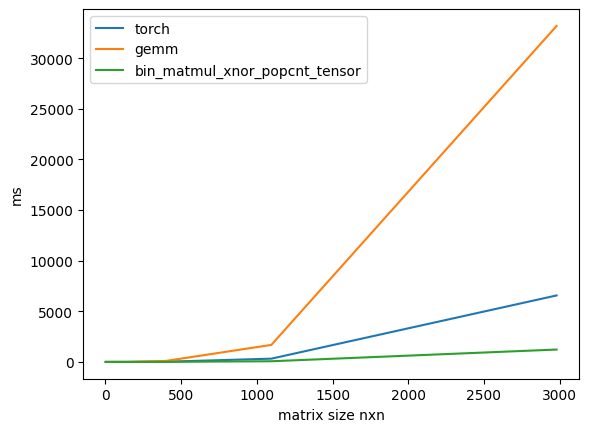

In [7]:
plt.plot(res["n"], res["torch mean_ms"], label="torch")
plt.plot(res["n"], res["gemm mean_ms"], label="gemm")
plt.plot(res["n"], res["bin_matmul_xnor_popcnt_tensor mean_ms"], label="bin_matmul_xnor_popcnt_tensor")
plt.ylabel("ms")
plt.xlabel("matrix size nxn")
plt.legend()

In [8]:
res = {
    "n": [],
    "torch mean_ms": [],
    "torch std_ms": [],
    "bin_matmul_xnor_popcnt_tensor mean_ms": [],
    "bin_matmul_xnor_popcnt_tensor std_ms": [],
}

for i in tqdm(range(1, 9)):
    n = int(torch.e ** i)
    res["n"].append(n)

    A = torch.randint(0, 2, (n, n), dtype=torch.float32)
    A = (A-A.mean()).sign()
    B = torch.randint(0, 2, (n, n), dtype=torch.float32)
    B = (B-B.mean()).sign()

    r_torch = timeit_ms(torch.matmul, A, B, repeat=3, warmup=1)
    res["torch mean_ms"].append(r_torch["mean_ms"])
    res["torch std_ms"].append(r_torch["std_ms"])

    r_bin_matmul_xnor_popcnt_tensor = timeit_ms(bin_matmul_xnor_popcnt_tensor, A, B, repeat=3, warmup=1)
    res["bin_matmul_xnor_popcnt_tensor mean_ms"].append(r_bin_matmul_xnor_popcnt_tensor["mean_ms"])
    res["bin_matmul_xnor_popcnt_tensor std_ms"].append(r_bin_matmul_xnor_popcnt_tensor["std_ms"])

100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


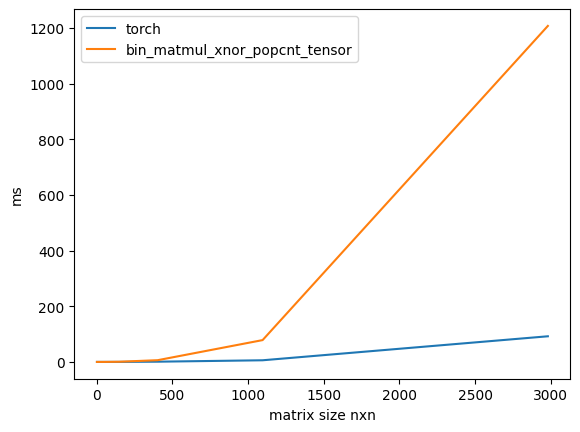

In [9]:
plt.plot(res["n"], res["torch mean_ms"], label="torch")
plt.plot(res["n"], res["bin_matmul_xnor_popcnt_tensor mean_ms"], label="bin_matmul_xnor_popcnt_tensor")
plt.ylabel("ms")
plt.xlabel("matrix size nxn")
plt.legend()